In [ ]:
# Task_1 - Quesiton_2 - a)

In [ ]:
import os 
import torch
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn
from PIL import Image
from networks import ConvNet  
from torchinfo import summary  

# FLOPs calculation function
def compute_flops(model, input_dimensions):
    model_summary = summary(model, input_size=input_dimensions, verbose=0)
    return model_summary.total_mult_adds

# Custom Dataset class for MHIST data
class HistologyDataset(Dataset):
    
    def __init__(self, image_dir, csv_file, partition="train", transform=None):
        self.image_dir = image_dir
        self.transform = transform
        
        # Load and filter the CSV file based on partition
        labels_data = pd.read_csv(csv_file)
        labels_data = labels_data[labels_data['Partition'] == partition]
        self.label_encoding = {'HP': 0, 'SSA': 1}
        labels_data['Encoded Label'] = labels_data['Majority Vote Label'].map(self.label_encoding)
        
        # Get file paths and labels
        self.image_filenames = labels_data['Image Name'].tolist()
        self.image_labels = labels_data['Encoded Label'].tolist()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_filenames[index])
        label = self.image_labels[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    
# Main training and evaluation function
def train_MHIST_model(dataset_name, network_depth, epochs, image_folder, csv_file, batch_size=32, learning_rate=0.01):
    # Dataset parameters and transformations
    num_channels = 3
    image_size = (128, 128)
    num_classes = 2
    mean, std_dev = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    
    # Check dataset type
    if dataset_name != 'MHIST':
        raise ValueError("This function only supports the 'MHIST' dataset.")
    transform_pipeline = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std_dev)
    ])

    # Load datasets
    training_data = HistologyDataset(image_dir=image_folder, csv_file=csv_file, partition="train", transform=transform_pipeline)
    testing_data = HistologyDataset(image_dir=image_folder, csv_file=csv_file, partition="test", transform=transform_pipeline)

    # DataLoaders
    training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=0)
    testing_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=False, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Initialize the model
    model = ConvNet(
        channel=num_channels,
        num_classes=num_classes,
        net_width=128,
        net_depth=network_depth,
        net_act='relu',
        net_norm='instancenorm',
        net_pooling='avgpooling',
        im_size=image_size
    ).to(device)

    # Define loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss, correct_predictions, total_samples = 0.0, 0, 0
        for images, labels in training_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * labels.size(0)
            _, predicted_labels = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()
        
        scheduler.step()

        # Epoch results
        avg_loss = epoch_loss / total_samples
        accuracy = 100 * correct_predictions / total_samples
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Evaluation
    model.eval()
    correct_predictions, total_samples = 0, 0
    with torch.no_grad():
        for images, labels in testing_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_labels = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()

    test_accuracy = 100 * correct_predictions / total_samples
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Calculate FLOPs
    input_dimensions = (1, num_channels, image_size[0], image_size[1])
    flops = compute_flops(model, input_dimensions)
    print(f"FLOPs for {dataset_name}: {flops:.2e}")
    return model, test_accuracy, flops

# Example usage for MHIST dataset
if __name__ == "__main__":
    histology_model, histology_test_accuracy, histology_flops = train_MHIST_model(
        dataset_name='MHIST',
        network_depth=7,
        epochs=20,
        image_folder='./mhist_dataset/images',  
        csv_file='./mhist_dataset/annotations.csv',  
    )


Epoch [1/20], Loss: 0.6156, Accuracy: 71.03%
Epoch [2/20], Loss: 0.5983, Accuracy: 71.03%
Epoch [3/20], Loss: 0.5801, Accuracy: 71.03%
Epoch [4/20], Loss: 0.5617, Accuracy: 71.54%
Epoch [5/20], Loss: 0.5295, Accuracy: 72.60%
Epoch [6/20], Loss: 0.4970, Accuracy: 77.06%
Epoch [7/20], Loss: 0.4732, Accuracy: 79.40%
Epoch [8/20], Loss: 0.4294, Accuracy: 81.98%
Epoch [9/20], Loss: 0.3856, Accuracy: 84.83%
Epoch [10/20], Loss: 0.3430, Accuracy: 87.31%
Epoch [11/20], Loss: 0.3128, Accuracy: 89.29%
Epoch [12/20], Loss: 0.2698, Accuracy: 91.91%
Epoch [13/20], Loss: 0.2157, Accuracy: 95.45%
Epoch [14/20], Loss: 0.1756, Accuracy: 97.33%
Epoch [15/20], Loss: 0.1397, Accuracy: 98.53%
Epoch [16/20], Loss: 0.1185, Accuracy: 98.80%
Epoch [17/20], Loss: 0.1043, Accuracy: 99.26%
Epoch [18/20], Loss: 0.0968, Accuracy: 99.31%
Epoch [19/20], Loss: 0.0927, Accuracy: 99.45%
Epoch [20/20], Loss: 0.0910, Accuracy: 99.49%
Test Accuracy: 79.53%
FLOPs for MHIST: 8.65e+08


In [ ]:
# Task_1 - Quesiton_2 - b) & c) & e)

Epoch 1/20
Epoch [1/20], Loss: 0.1375, Accuracy: 95.25%
Epoch 2/20
Epoch [2/20], Loss: 0.1343, Accuracy: 95.41%
Epoch 3/20
Epoch [3/20], Loss: 0.1392, Accuracy: 95.13%
Epoch 4/20
Epoch [4/20], Loss: 0.1312, Accuracy: 95.56%
Epoch 5/20
Epoch [5/20], Loss: 0.1356, Accuracy: 95.41%
Epoch 6/20
Epoch [6/20], Loss: 0.1298, Accuracy: 95.70%
Epoch 7/20
Epoch [7/20], Loss: 0.1339, Accuracy: 95.43%
Epoch 8/20
Epoch [8/20], Loss: 0.1395, Accuracy: 95.27%
Epoch 9/20
Epoch [9/20], Loss: 0.1409, Accuracy: 95.15%
Epoch 10/20
Epoch [10/20], Loss: 0.1340, Accuracy: 95.52%
Epoch 11/20
Epoch [11/20], Loss: 0.1403, Accuracy: 95.11%
Epoch 12/20
Epoch [12/20], Loss: 0.1344, Accuracy: 95.48%
Epoch 13/20
Epoch [13/20], Loss: 0.1353, Accuracy: 95.44%
Epoch 14/20
Epoch [14/20], Loss: 0.1400, Accuracy: 95.36%
Epoch 15/20
Epoch [15/20], Loss: 0.1501, Accuracy: 94.97%
Epoch 16/20
Epoch [16/20], Loss: 0.1394, Accuracy: 95.28%
Epoch 17/20
Epoch [17/20], Loss: 0.1366, Accuracy: 95.38%
Epoch 18/20
Epoch [18/20], Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5280198..2.587712].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1078379..2.5702891].


Synthetic dataset saved to ./synthetic_mhist.pt


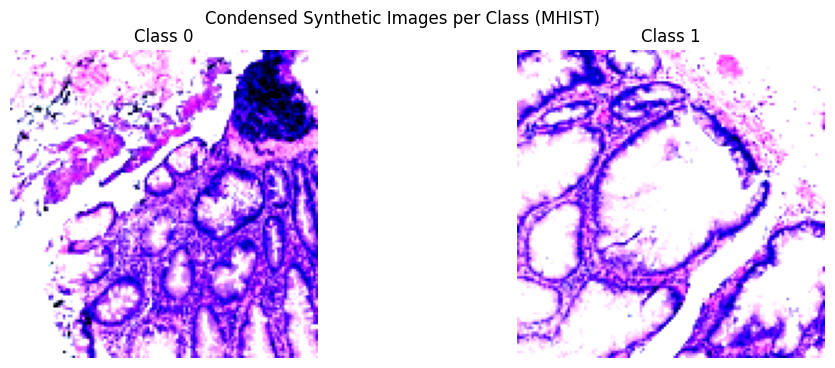

Test Accuracy after Attention Matching: 65.51%


In [ ]:
import os
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from networks import ConvNet
from utils import get_dataset

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class for MHIST data
class HistologyDataset(Dataset):
    def __init__(self, image_dir, csv_file, partition="train", transform=None):
        self.image_dir = image_dir
        self.transform = transform
        labels_data = pd.read_csv(csv_file)
        labels_data = labels_data[labels_data['Partition'] == partition]
        self.label_encoding = {'HP': 0, 'SSA': 1}
        labels_data['Encoded Label'] = labels_data['Majority Vote Label'].map(self.label_encoding)
        self.image_filenames = labels_data['Image Name'].tolist()
        self.image_labels = labels_data['Encoded Label'].tolist()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_filenames[index])
        label = self.image_labels[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Synthetic Dataset for Attention Matching
class SyntheticMHISTDataset(Dataset):
    def __init__(self, real_dataset, num_classes=2, images_per_class=50):
        self.synthetic_data = []
        self.synthetic_labels = []
        self._initialize_synthetic_data(real_dataset, num_classes, images_per_class)

    def _initialize_synthetic_data(self, real_dataset, num_classes, images_per_class):
        images_by_class = {i: [] for i in range(num_classes)}
        for img, label in real_dataset:
            images_by_class[label].append(img)
        for class_idx in range(num_classes):
            selected_images = random.sample(images_by_class[class_idx], images_per_class)
            class_tensor = torch.stack([img for img in selected_images]).to(device).requires_grad_(True)
            self.synthetic_data.append(class_tensor)
            self.synthetic_labels += [class_idx] * images_per_class

    def __len__(self):
        return len(self.synthetic_data) * self.synthetic_data[0].shape[0]

    def __getitem__(self, idx):
        class_idx = idx // len(self.synthetic_data[0])
        img_idx = idx % len(self.synthetic_data[0])
        return self.synthetic_data[class_idx][img_idx], self.synthetic_labels[idx]
# Function to save synthetic data
def save_synthetic_data(synthetic_data, synthetic_labels, path="./synthetic_mhist.pt"):
    data_dict = {
        "synthetic_data": [sd.cpu() for sd in synthetic_data],  # Move data to CPU if on GPU
        "synthetic_labels": synthetic_labels.cpu()  # Move labels to CPU if on GPU
    }
    torch.save(data_dict, path)
    print(f"Synthetic dataset saved to {path}")

# Attention Matching Function
def run_attention_matching_mhist(
    num_synthetic_steps=10,           # Number of optimization steps for synthetic data
    num_weight_reinitializations=20,  # Number of times to reinitialize model weights
    synthetic_lr=0.1,                 # Learning rate for synthetic sample updates
    synthetic_iterations=1,           # Number of synthetic optimization steps per epoch
    model_lr=0.01,                    # Learning rate for model optimization
    model_iterations=50,              # Number of model optimization steps per epoch
    attention_lambda=0.01,            # Weight for attention loss
    num_epochs=20,                    # Number of training epochs
    images_per_class=50,              # Number of images per class in synthetic dataset
    minibatch_size=128                # Batch size for real data
):
    # Data transformations
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load MHIST dataset
    train_dataset = HistologyDataset(image_dir='./mhist_dataset/images', csv_file='./mhist_dataset/annotations.csv', partition="train", transform=transform)
    test_dataset = HistologyDataset(image_dir='./mhist_dataset/images', csv_file='./mhist_dataset/annotations.csv', partition="test", transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

    # Synthetic data for Attention Matching
    synthetic_dataset = SyntheticMHISTDataset(train_dataset, num_classes=2, images_per_class=images_per_class)
    synthetic_loader = DataLoader(synthetic_dataset, batch_size=images_per_class, shuffle=False)

    # Start Attention Matching process
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_loss = 0
        correct, total = 0, 0

        # Run model training with num_weight_reinitializations random weight initializations
        for _ in range(num_weight_reinitializations):
            model = ConvNet(channel=3, num_classes=2, net_width=128, net_depth=7, net_act='relu', net_norm='batchnorm', net_pooling='avgpooling', im_size=(128, 128)).to(device)
            model_optimizer = optim.SGD(model.parameters(), lr=model_lr, momentum=0.9)
            criterion = nn.CrossEntropyLoss()

            # Model training on synthetic data
            for update_step in range(model_iterations):
                synthetic_inputs = torch.cat([sd.clone().detach().requires_grad_(True) for sd in synthetic_dataset.synthetic_data]).to(device)
                synthetic_labels = torch.tensor(synthetic_dataset.synthetic_labels, device=device)
                model_output = model(synthetic_inputs)
                model_loss = criterion(model_output, synthetic_labels)
                model_optimizer.zero_grad()
                model_loss.backward()
                model_optimizer.step()
                epoch_loss += model_loss.item()
                _, predicted = model_output.max(1)
                total += synthetic_labels.size(0)
                correct += predicted.eq(synthetic_labels).sum().item()

        accuracy = 100. * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / (num_weight_reinitializations * model_iterations):.4f}, Accuracy: {accuracy:.2f}%")

        # Update synthetic data with attention matching
        for synthetic_step in range(num_synthetic_steps):
            for class_idx, synthetic_class_data in enumerate(synthetic_dataset.synthetic_data):
                synthetic_class_data = synthetic_class_data.clone().detach().requires_grad_(True)
                synthetic_optimizer = optim.SGD([synthetic_class_data], lr=synthetic_lr)
                real_images, _ = next(iter(train_loader))
                real_images = real_images.to(device)
                model.eval()
                synthetic_output = model(synthetic_class_data)
                real_output = model(real_images)
                attention_loss = attention_lambda * ((synthetic_output - real_output[:images_per_class].detach()) ** 2).mean()
                synthetic_optimizer.zero_grad()
                attention_loss.backward()
                synthetic_optimizer.step()
                synthetic_dataset.synthetic_data[class_idx] = synthetic_class_data.detach().requires_grad_(True)
    
    save_synthetic_data(synthetic_dataset.synthetic_data, torch.tensor(synthetic_dataset.synthetic_labels))
    visualize_synthetic_images(synthetic_dataset.synthetic_data)
    evaluate_model(model, test_loader)

# Visualization Function
def visualize_synthetic_images(synthetic_data):
    num_classes = len(synthetic_data)
    fig, axes = plt.subplots(1, num_classes, figsize=(12, 4))
    
    for class_idx, class_data in enumerate(synthetic_data):
        image = class_data[0].detach().cpu().squeeze().permute(1, 2, 0) 
        axes[class_idx].imshow(image.numpy()) 
        axes[class_idx].axis("off")
        axes[class_idx].set_title(f"Class {class_idx}")

    plt.suptitle("Condensed Synthetic Images per Class (MHIST)")
    plt.show()

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100. * correct / total
    print(f"Test Accuracy after Attention Matching: {test_accuracy:.2f}%")

# Run the Attention Matching on MHIST
run_attention_matching_mhist()


In [ ]:
# Task_1 - Q_2 - c) & d) & e) with Gaussian noise

Epoch 1/20
Epoch [1/20], Loss: 0.1543, Accuracy: 95.02%
Epoch 2/20
Epoch [2/20], Loss: 0.1515, Accuracy: 95.19%
Epoch 3/20
Epoch [3/20], Loss: 0.1521, Accuracy: 95.01%
Epoch 4/20
Epoch [4/20], Loss: 0.1582, Accuracy: 94.87%
Epoch 5/20
Epoch [5/20], Loss: 0.1670, Accuracy: 94.47%
Epoch 6/20
Epoch [6/20], Loss: 0.1560, Accuracy: 94.85%
Epoch 7/20
Epoch [7/20], Loss: 0.1510, Accuracy: 94.96%
Epoch 8/20
Epoch [8/20], Loss: 0.1558, Accuracy: 94.99%
Epoch 9/20
Epoch [9/20], Loss: 0.1512, Accuracy: 95.13%
Epoch 10/20
Epoch [10/20], Loss: 0.1547, Accuracy: 95.02%
Epoch 11/20
Epoch [11/20], Loss: 0.1543, Accuracy: 94.91%
Epoch 12/20
Epoch [12/20], Loss: 0.1573, Accuracy: 94.82%
Epoch 13/20
Epoch [13/20], Loss: 0.1556, Accuracy: 94.88%
Epoch 14/20
Epoch [14/20], Loss: 0.1578, Accuracy: 94.80%
Epoch 15/20
Epoch [15/20], Loss: 0.1541, Accuracy: 95.00%
Epoch 16/20
Epoch [16/20], Loss: 0.1561, Accuracy: 94.97%
Epoch 17/20
Epoch [17/20], Loss: 0.1558, Accuracy: 95.02%
Epoch 18/20
Epoch [18/20], Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.002623079..1.0022962].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0018191735..1.0013967].


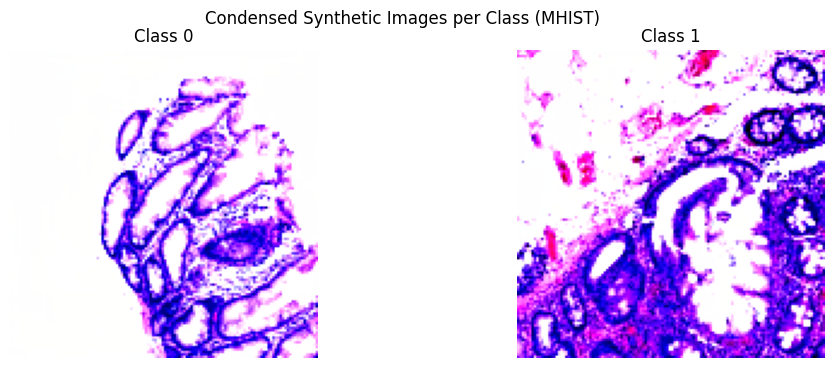

Test Accuracy after Attention Matching: 63.25%


In [ ]:
import os
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from scipy.ndimage import gaussian_filter
from networks import ConvNet
from utils import get_dataset

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to create Gaussian noise with low-pass filtering
def create_low_pass_gaussian_noise(shape, mean=0.0, std=0.1, sigma=1.0):
    noise = np.random.normal(mean, std, shape)
    low_pass_noise = gaussian_filter(noise, sigma=sigma)  # Apply Gaussian filter
    return torch.tensor(low_pass_noise, dtype=torch.float32)

# Custom Dataset class for MHIST data
class HistologyDataset(Dataset):
    def __init__(self, image_dir, csv_file, partition="train", transform=None):
        self.image_dir = image_dir
        self.transform = transform
        labels_data = pd.read_csv(csv_file)
        labels_data = labels_data[labels_data['Partition'] == partition]
        self.label_encoding = {'HP': 0, 'SSA': 1}
        labels_data['Encoded Label'] = labels_data['Majority Vote Label'].map(self.label_encoding)
        self.image_filenames = labels_data['Image Name'].tolist()
        self.image_labels = labels_data['Encoded Label'].tolist()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_filenames[index])
        label = self.image_labels[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Synthetic Dataset for Attention Matching with low-pass Gaussian noise
class SyntheticMHISTDataset(Dataset):
    def __init__(self, real_dataset, num_classes=2, images_per_class=50, noise_std=0.1, noise_sigma=1.0):
        self.synthetic_data = []
        self.synthetic_labels = []
        self.noise_std = noise_std
        self.noise_sigma = noise_sigma
        self._initialize_synthetic_data(real_dataset, num_classes, images_per_class)

    def _initialize_synthetic_data(self, real_dataset, num_classes, images_per_class):
        images_by_class = {i: [] for i in range(num_classes)}
        for img, label in real_dataset:
            images_by_class[label].append(img)

        for class_idx in range(num_classes):
            # Select real images and add low-pass Gaussian noise
            selected_images = random.sample(images_by_class[class_idx], images_per_class)
            noisy_images = []
            for img in selected_images:
                img = img.to(device)  
                noise = create_low_pass_gaussian_noise(img.shape, std=self.noise_std, sigma=self.noise_sigma).to(device)
                noisy_img = (img + noise).clamp(0, 1)  
                noisy_images.append(noisy_img)
            
            class_tensor = torch.stack(noisy_images).to(device).requires_grad_(True)
            self.synthetic_data.append(class_tensor)
            self.synthetic_labels += [class_idx] * images_per_class

    def __len__(self):
        return len(self.synthetic_data) * self.synthetic_data[0].shape[0]

    def __getitem__(self, idx):
        class_idx = idx // len(self.synthetic_data[0])
        img_idx = idx % len(self.synthetic_data[0])
        return self.synthetic_data[class_idx][img_idx], self.synthetic_labels[idx]
# Function to save synthetic data
def save_synthetic_data(synthetic_data, synthetic_labels, path="./synthetic_mhist_noise.pt"):
    data_dict = {
        "synthetic_data": [sd.cpu() for sd in synthetic_data], 
        "synthetic_labels": synthetic_labels.cpu() 
    }
    torch.save(data_dict, path)
    print(f"Synthetic dataset saved to {path}")

# Attention Matching Function
def run_attention_matching_mhist(
    T=10, K=20, eta_S=0.1, zeta_S=1, eta_theta=0.01, zeta_theta=50, lambda_param=0.01, num_epochs=20, images_per_class=50, minibatch_size=128
):
    # Data transformations
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load MHIST dataset
    train_dataset = HistologyDataset(image_dir='./mhist_dataset/images', csv_file='./mhist_dataset/annotations.csv', partition="train", transform=transform)
    test_dataset = HistologyDataset(image_dir='./mhist_dataset/images', csv_file='./mhist_dataset/annotations.csv', partition="test", transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

    # Synthetic data with low-pass Gaussian noise
    synthetic_dataset = SyntheticMHISTDataset(train_dataset, num_classes=2, images_per_class=images_per_class, noise_std=0.1, noise_sigma=1.0)
    synthetic_loader = DataLoader(synthetic_dataset, batch_size=images_per_class, shuffle=False)

    # Start Attention Matching process
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_loss = 0
        correct, total = 0, 0

        # Model training
        for _ in range(K):
            model = ConvNet(channel=3, num_classes=2, net_width=128, net_depth=7, net_act='relu', net_norm='batchnorm', net_pooling='avgpooling', im_size=(128, 128)).to(device)
            model_optimizer = optim.SGD(model.parameters(), lr=eta_theta, momentum=0.9)
            criterion = nn.CrossEntropyLoss()

            for update_step in range(zeta_theta):
                synthetic_inputs = torch.cat([sd.clone().detach().requires_grad_(True) for sd in synthetic_dataset.synthetic_data]).to(device)
                synthetic_labels = torch.tensor(synthetic_dataset.synthetic_labels, device=device)
                model_output = model(synthetic_inputs)
                model_loss = criterion(model_output, synthetic_labels)
                model_optimizer.zero_grad()
                model_loss.backward()
                model_optimizer.step()
                epoch_loss += model_loss.item()
                _, predicted = model_output.max(1)
                total += synthetic_labels.size(0)
                correct += predicted.eq(synthetic_labels).sum().item()

        accuracy = 100. * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / (K * zeta_theta):.4f}, Accuracy: {accuracy:.2f}%")

        # Update synthetic data with attention matching
        for synthetic_step in range(T):
            for class_idx, synthetic_class_data in enumerate(synthetic_dataset.synthetic_data):
                synthetic_class_data = synthetic_class_data.clone().detach().requires_grad_(True)
                synthetic_optimizer = optim.SGD([synthetic_class_data], lr=eta_S)
                real_images, _ = next(iter(train_loader))
                real_images = real_images.to(device)
                model.eval()
                synthetic_output = model(synthetic_class_data)
                real_output = model(real_images)
                attention_loss = lambda_param * ((synthetic_output - real_output[:images_per_class].detach()) ** 2).mean()
                synthetic_optimizer.zero_grad()
                attention_loss.backward()
                synthetic_optimizer.step()
                synthetic_dataset.synthetic_data[class_idx] = synthetic_class_data.detach().requires_grad_(True)
    
    save_synthetic_data(synthetic_dataset.synthetic_data, torch.tensor(synthetic_dataset.synthetic_labels))
    visualize_synthetic_images(synthetic_dataset.synthetic_data)
    evaluate_model(model, test_loader)

# Visualization Function
def visualize_synthetic_images(synthetic_data):
    num_classes = len(synthetic_data)
    fig, axes = plt.subplots(1, num_classes, figsize=(12, 4))
    
    for class_idx, class_data in enumerate(synthetic_data):
        image = class_data[0].detach().cpu().squeeze().permute(1, 2, 0)
        axes[class_idx].imshow(image.numpy())
        axes[class_idx].axis("off")
        axes[class_idx].set_title(f"Class {class_idx}")

    plt.suptitle("Condensed Synthetic Images per Class (MHIST)")
    plt.show()

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100. * correct / total
    print(f"Test Accuracy after Attention Matching: {test_accuracy:.2f}%")

# Run the Attention Matching on MHIST
run_attention_matching_mhist()


In [ ]:
# Question 3

In [ ]:
import os
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from PIL import Image
from utils import get_network 
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class for MHIST data
class HistologyDataset(Dataset):
    def __init__(self, image_dir, csv_file, partition="train", transform=None):
        self.image_dir = image_dir
        self.transform = transform
        labels_data = pd.read_csv(csv_file)
        labels_data = labels_data[labels_data['Partition'] == partition]
        self.label_encoding = {'HP': 0, 'SSA': 1}
        labels_data['Encoded Label'] = labels_data['Majority Vote Label'].map(self.label_encoding)
        self.image_filenames = labels_data['Image Name'].tolist()
        self.image_labels = labels_data['Encoded Label'].tolist()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_filenames[index])
        label = self.image_labels[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Function to load synthetic dataset from file
def load_synthetic_data(path="./synthetic_mhist.pt"):
    data_dict = torch.load(path)
    synthetic_data = torch.cat(data_dict["synthetic_data"]).to(device)  # Concatenate tensors and move to device
    synthetic_labels = torch.tensor(data_dict["synthetic_labels"]).to(device)
    return synthetic_data, synthetic_labels

# Function to train the model on synthetic data
def train_model_on_synthetic(model, synthetic_data, synthetic_labels, num_epochs=20, lr=0.01):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Create a DataLoader from synthetic data for training
    synthetic_dataset = TensorDataset(synthetic_data, synthetic_labels)
    synthetic_loader = DataLoader(synthetic_dataset, batch_size=64, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in synthetic_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(synthetic_loader):.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100. * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy

# Main function to load synthetic data, train model, and evaluate
def main():
    # Load synthetic MHIST dataset
    synthetic_data_path = "./synthetic_mhist.pt"
    synthetic_data, synthetic_labels = load_synthetic_data(synthetic_data_path)

    # Set up data transformations
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load MHIST dataset for testing
    train_dataset = HistologyDataset(image_dir='./mhist_dataset/images', csv_file='./mhist_dataset/annotations.csv', partition="train", transform=transform)
    test_dataset = HistologyDataset(image_dir='./mhist_dataset/images', csv_file='./mhist_dataset/annotations.csv', partition="test", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize model using get_network with appropriate parameters
    model = get_network("LeNet", channel=3, num_classes=2, im_size=(128, 128)).to(device)

    # Train model on synthetic MHIST dataset
    print("Training LeNet on synthetic MHIST data...")
    train_model_on_synthetic(model, synthetic_data, synthetic_labels, num_epochs=20, lr=0.01)

    # Evaluate model on the original MHIST test set
    print("Evaluating LeNet on the MHIST test set...")
    test_accuracy = evaluate_model(model, test_loader)
    print(f"Final Test Accuracy on MHIST test set: {test_accuracy:.2f}%")

# Run the main function
if __name__ == "__main__":
    main()


/tmp/ipykernel_2260/654713871.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  synthetic_labels = torch.tensor(data_dict["synthetic_labels"]).to(device)


Training ConvNet on synthetic MHIST data...
Epoch [1/20], Loss: 2.4230
Epoch [2/20], Loss: 17.5940
Epoch [3/20], Loss: 19.2053
Epoch [4/20], Loss: 13.8067
Epoch [5/20], Loss: 11.1252
Epoch [6/20], Loss: 3.6915
Epoch [7/20], Loss: 5.8167
Epoch [8/20], Loss: 3.1144
Epoch [9/20], Loss: 1.5963
Epoch [10/20], Loss: 1.3138
Epoch [11/20], Loss: 0.2614
Epoch [12/20], Loss: 0.7477
Epoch [13/20], Loss: 0.0563
Epoch [14/20], Loss: 0.0171
Epoch [15/20], Loss: 0.0474
Epoch [16/20], Loss: 0.0018
Epoch [17/20], Loss: 0.0170
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0000
Evaluating ConvNet on the MHIST test set...
Test Accuracy: 52.61%
Final Test Accuracy on MHIST test set: 52.61%


In [ ]:
# Question 4

In [ ]:
import os
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from PIL import Image
from utils import get_network  

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class for MHIST data
class HistologyDataset(Dataset):
    def __init__(self, image_dir, csv_file, partition="train", transform=None):
        self.image_dir = image_dir
        self.transform = transform
        labels_data = pd.read_csv(csv_file)
        labels_data = labels_data[labels_data['Partition'] == partition]
        self.label_encoding = {'HP': 0, 'SSA': 1}
        labels_data['Encoded Label'] = labels_data['Majority Vote Label'].map(self.label_encoding)
        self.image_filenames = labels_data['Image Name'].tolist()
        self.image_labels = labels_data['Encoded Label'].tolist()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_filenames[index])
        label = self.image_labels[index]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Function to load synthetic dataset from file
def load_synthetic_data(path="./synthetic_mhist.pt"):
    data_dict = torch.load(path)
    synthetic_data = torch.cat(data_dict["synthetic_data"]).to(device)  
    synthetic_labels = torch.tensor(data_dict["synthetic_labels"]).to(device)
    return synthetic_data, synthetic_labels

# Function to train the model on synthetic data
def train_model_on_synthetic(model, synthetic_data, synthetic_labels, num_epochs=20, lr=0.01):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Create a DataLoader from synthetic data for training
    synthetic_dataset = TensorDataset(synthetic_data, synthetic_labels)
    synthetic_loader = DataLoader(synthetic_dataset, batch_size=64, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in synthetic_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(synthetic_loader):.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100. * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy

# Main function to load synthetic data, train model, and evaluate
def main():
    # Load synthetic MHIST dataset
    synthetic_data_path = "./synthetic_mhist_noise.pt"
    synthetic_data, synthetic_labels = load_synthetic_data(synthetic_data_path)

    # Set up data transformations
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load MHIST dataset for testing
    train_dataset = HistologyDataset(image_dir='./mhist_dataset/images', csv_file='./mhist_dataset/annotations.csv', partition="train", transform=transform)
    test_dataset = HistologyDataset(image_dir='./mhist_dataset/images', csv_file='./mhist_dataset/annotations.csv', partition="test", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize model using get_network with appropriate parameters
    model = get_network("LeNet", channel=3, num_classes=2, im_size=(128, 128)).to(device)

    # Train model on synthetic MHIST dataset
    print("Training LeNet on synthetic MHIST data...")
    train_model_on_synthetic(model, synthetic_data, synthetic_labels, num_epochs=20, lr=0.01)

    # Evaluate model on the original MHIST test set
    print("Evaluating LeNet on the MHIST test set...")
    test_accuracy = evaluate_model(model, test_loader)
    print(f"Final Test Accuracy on MHIST test set: {test_accuracy:.2f}%")

# Run the main function
if __name__ == "__main__":
    main()


/tmp/ipykernel_2260/3860439385.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  synthetic_labels = torch.tensor(data_dict["synthetic_labels"]).to(device)


Training ConvNet on synthetic MHIST data...
Epoch [1/20], Loss: 1.0739
Epoch [2/20], Loss: 11.9592
Epoch [3/20], Loss: 26.1512
Epoch [4/20], Loss: 9.1048
Epoch [5/20], Loss: 17.2191
Epoch [6/20], Loss: 2.7372
Epoch [7/20], Loss: 2.9298
Epoch [8/20], Loss: 3.8291
Epoch [9/20], Loss: 1.5834
Epoch [10/20], Loss: 1.0924
Epoch [11/20], Loss: 0.2943
Epoch [12/20], Loss: 1.0980
Epoch [13/20], Loss: 0.1547
Epoch [14/20], Loss: 0.1732
Epoch [15/20], Loss: 0.2336
Epoch [16/20], Loss: 0.0002
Epoch [17/20], Loss: 0.0000
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0035
Epoch [20/20], Loss: 0.0163
Evaluating ConvNet on the MHIST test set...
Test Accuracy: 59.06%
Final Test Accuracy on MHIST test set: 59.06%
